In [12]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import HTML, IFrame
import ROOT
from ROOT import RooFit
%matplotlib inline

In [3]:
HTML('<link rel="stylesheet" href="custom.css" type="text/css">')

In [4]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
          'theme': 'sans',
          'transition': 'zoom',
})

{u'start_slideshow_at': 3, u'theme': 'sans', u'transition': 'zoom'}

# Lecture 1

<p style="text-align: center;"><i class="icon-user icon-2x"> [ruggero.turra@mi.infn.it](mailto:ruggero.turra@mi.infn.it)</i></p>

## Content of the day

   * Basic notion you should already have
   * Introduction to inferential statistics

## Intro to the lectures
   * This is not a course on [RooFit](https://root.cern.ch/roofit) / [RooStats](https://twiki.cern.ch/twiki/bin/view/RooStats/WebTopicList) / ...
   * This is not a course of python / [numpy](http://www.numpy.org/) / [matplotlib](http://matplotlib.org/) / ...
   * I have just collected some examples that can be interested for your studies with the minimal-needed theory

<small>
These lectures are available on my [GitHub repository](https://github.com/wiso/StatisticsLectures) as [jupyter](http://jupyter.org/) (previous [ipython](http://ipython.org/) notebook) notebook. They can be shown as interactive slides using [RISE](https://github.com/damianavila/RISE).</small>

## Resources

* [Kyle Cranmer](http://orcid.org/0000-0002-5769-7094) [lectures](https://indico.cern.ch/event/117033/other-view?view=standard) and [proceedings](https://cds.cern.ch/record/2004587/files/arXiv:1503.07622.pdf) at 2011 ESHEP (see page 3 for many books)
* Kyle Cranmer [lectures](https://indico.cern.ch/event/243641/) for summer students in 2013

In [5]:
HTML('''<iframe width="49%" height="300" src="https://indico.cern.ch/event/117033/contribution/19/attachments/55755/80228/Cranmer_L1.pdf" frameborder="0" allowfullscreen></iframe>
     <iframe width="49%" height="300" src="https://indico.cern.ch/event/243641/" frameborder="0" allowfullscreen></iframe>''')

[Luca Lista](http://people.na.infn.it/~lista/Statistics/) with RooStats examples

In [6]:
IFrame('http://people.na.infn.it/~lista/Statistics/', width=900, height=400)

LHC discovery related:

   * Eilam Gross [LHC Statistics for Pedestrians](http://cds.cern.ch/record/1099994/files/p205.pdf)
   * [Asymptotic formulae for likelihood-based tests of new physics](http://arxiv.org/pdf/1007.1727v3.pdf)
   * [Procedure for the LHC Higgs boson search
combination in Summer 2011](https://cds.cern.ch/record/1379837/files/NOTE2011_005.pdf)

   
Others:
   * Gerhard Bohm, Günter Zech ["Introduction to Statistics and Data
Analysis for Physicists"](http://www-library.desy.de/preparch/books/vstatmp_engl.pdf)
   * Roger Barlow ["Systematic Errors: Facts and Fictions"](http://arxiv.org/pdf/hep-ex/0207026v1.pdf)
   * Grégory Schott [RooStats for Searches](http://indico.cern.ch/event/107747/contribution/25/attachments/24332/35016/schott_2011.01.17__RooStats_talk.pdf)


   * Statistics seems easy, since usually problems can described with a simple language. But it is not...
   * Easy questions: do we have discovered the Higgs boson?

## Basic concepts you should already have

   * <strong>Expected value</strong> of a random variable $X$:   
   $E[X] = \mu = \int x f_X(x) dx$
   * <strong>Variance</strong>:   
   $V[X] = E[(X - \mu)^2]$
   * <strong>Covariance</strong>:   
   $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]} = \\
   \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right]\operatorname{E}\left[Y\right]$

   * <strong>Mean of a sample</strong>: $\bar x = \frac{1}{n}\sum{x_i}$

### Exercize
   * Having a sample $\{x_i\}_i^n$, it is well know that $s^2 = \frac{1}{n-1} \sum_{i=1}^n \left(x_i - \overline{x} \right)^2$ is a unbiased estimator ($E[\text{bias}]=E[s^2 - V[X]) = 0$) for the variance
   * Show analytically that $\sqrt{s^2}$ is not an unbiased estimator for the standard deviation $\sigma_X=\sqrt{V[X]}$ (hint: $E$ is linear, $\sqrt{\,\,\,}$ is not)

#### Non-analytical solution

Let generate many toys, to see the bias of $\sqrt{s^2}$. Every toy is made by a normal sample.

In [7]:
POPULATION_STD_DEV = 3
SIZE = 5
NTOYS = 1000

all_bias_std, all_bias_std_corr = [], []

for itoy in range(NTOYS):
    # generate a sample
    sample = np.random.normal(loc=0., scale=POPULATION_STD_DEV,
                              size=SIZE)
    
    # compute the std with the two definitions
    all_bias_std.append(np.std(sample) - POPULATION_STD_DEV)
    all_bias_std_corr.append(np.std(sample, ddof=1) - POPULATION_STD_DEV)

Much faster code with vectorization

In [8]:
NTOYS = 1000000
samples = np.random.normal(loc=0., scale=POPULATION_STD_DEV, size=(NTOYS, 5))
all_bias_std = np.std(samples, axis=1) - POPULATION_STD_DEV
all_bias_std_corr = np.std(samples, axis=1, ddof=1) - POPULATION_STD_DEV

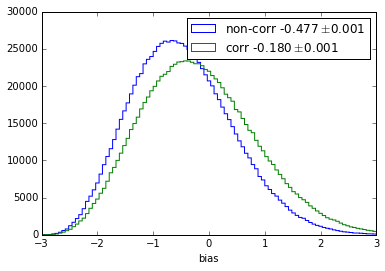

In [9]:
# plot it
mean_bias_non_corr, err_bias_non_corr = [f(all_bias_std) for f in (np.mean, stats.sem)]
mean_bias_corr, err_bias_corr = [f(all_bias_std_corr) for f in (np.mean, stats.sem)]
    
fig, ax = plt.subplots()
bins = np.linspace(-POPULATION_STD_DEV, POPULATION_STD_DEV, 100)
ax.hist(all_bias_std, bins, histtype='step', label='non-corr %.3f$\pm$%.3f' % (mean_bias_non_corr, err_bias_non_corr))
ax.hist(all_bias_std_corr, bins, histtype='step', label='corr %.3f$\pm$%.3f' % (mean_bias_corr, err_bias_corr))
ax.set_xlabel('bias'); ax.legend(); plt.show()

Can we draw a conclusions from these numbers? (answer=yes, detail in the rest of the lecture)

In [45]:
ws = ROOT.RooWorkspace('ws')
nbkg_exp = ws.factory("nbkg_exp[1000]")
n_exp = ws.factory("sum::n_exp(nsig_exp[100], nbkg_exp)")
pdf = ws.factory("Poisson::signal(n_obs[0, 10000], n_exp)")
aset = ROOT.RooArgSet(ws.var('n_obs'))
data = pdf.generate(aset, 1)
n_obs_val = data.get(0).first().getVal()

We expect to observe $s+b =$ {{ws.var('nsig_exp').getVal()}} + {{ws.var('nbkg_exp').getVal()}} = {{n_exp.getVal()}} events if there is a signal and {{ws.var('nbkg_exp').getVal()}} if there is only background. We observe {{n_obs_val}}. Is there a signal?

As first step compute the significance as $s / \sqrt{b}$

In [54]:
(n_obs_val - nbkg_exp.getVal()) / np.sqrt(nbkg_exp.getVal())

1.83412104289766